In [1]:
import os
import re


from pathlib import Path

import pandas as pd
import torch
import evaluate

from torch import nn
from tqdm.notebook import tqdm
# Tokenizers imports
from tokenizers import Tokenizer
from tokenizers import normalizers
from tokenizers import pre_tokenizers
from tokenizers.models import WordLevel, WordPiece
from tokenizers.processors import TemplateProcessing
from tokenizers.normalizers import NFC, StripAccents, Strip, Lowercase
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer

from matplotlib import pyplot as plt

from torch.utils.data import DataLoader, Dataset, Subset



from sklearn.model_selection import train_test_split

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# Dataset

Arabic English sentences pairs, originally obtaine from [Kaggle](https://www.kaggle.com/datasets/samirmoustafa/arabic-to-english-translation-sentences)

## Setup

In [3]:
data_dir = os.path.join(os.curdir, "data")
data_path = os.path.join(data_dir, "ara_eng.txt")


data = pd.read_csv(data_path, sep="\t", names=["target", "source"])

In [4]:
data

,target,source
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!
...,...,...
24633,rising voices promoting a more linguistically ...,شاركنا تحدي ابداع ميم بلغتك الام تعزيزا للتنوع...
24634,following last year s successful campaign we i...,استكمالا لنجاح حملة العام السابق ندعوكم للمشار...
24635,during last year s challenge we also met langu...,تعرفنا خلال تحدي العام الماضي على ابطال لغويين...
24636,to take part just follow the simple steps outl...,للمشاركة في التحدي اتبع الخطوات الموضحة على ال...


## Analysis

In [5]:
print(f"Total samples with duplicates = {len(data)}")

Total samples with duplicates = 24638


In [6]:
data = data[~data["target"].duplicated()]

In [7]:
print(f"Total samples without duplicates = {len(data)}")

Total samples without duplicates = 22834


In [8]:
lengths = [len(sentence.split(" ")) for sentence in data["source"].tolist()]

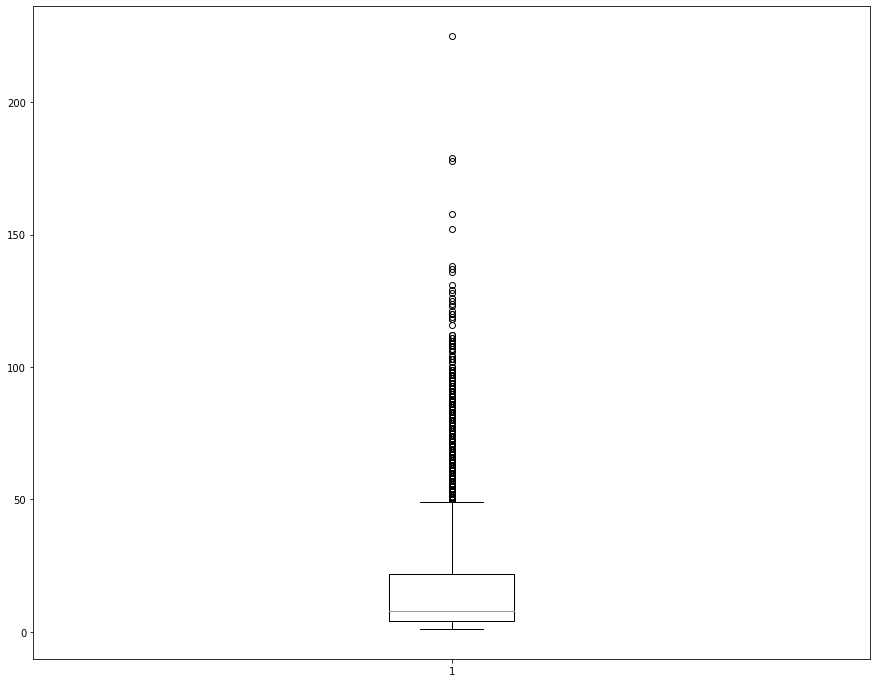

In [9]:
fig, ax = plt.subplots(figsize=(15, 12))

ax.boxplot(lengths)

plt.show()

## Preprocessing

In [10]:
punc_re = re.compile(r"""[!"#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~،؟…«“\":\"…”]""")
def remove_punctation(text: str) -> str:
    return punc_re.sub(repl="", string=text)


diactircs_re = re.compile("[\u064B-\u0652]")
def remove_diactrics(text: str) -> str:
    return diactircs_re.sub(repl="", string=text)

def clean_text(text: str) -> str:
    return remove_punctation(remove_diactrics(text))

In [11]:
data["target"] = data["target"].map(clean_text)
data["source"] = data["source"].map(clean_text)

/tmp/ipykernel_87059/3853276919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["target"] = data["target"].map(clean_text)
/tmp/ipykernel_87059/3853276919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["source"] = data["source"].map(clean_text)


## Train Test Split

In [12]:
train, test = train_test_split(data)

## Tokenization

In [13]:
normalizer = normalizers.Sequence([NFC(), StripAccents(), Lowercase(), Strip()])

In [14]:
post_processor = TemplateProcessing(
    single="[SOS] $A [EOS]",
    special_tokens=[("[SOS]", 2), ("[EOS]", 3)]
)

In [15]:
pre_tokenizer = pre_tokenizers.Sequence([Whitespace()])

In [16]:
ar_tokenizer = Tokenizer(model=WordLevel(unk_token="[OOV]"))
en_tokenizer = Tokenizer(model=WordLevel(unk_token="[OOV]"))

In [17]:
# arabic tokenizer
ar_tokenizer.normalizer = normalizer
ar_tokenizer.pre_tokenizer = pre_tokenizer
ar_tokenizer.post_processor = post_processor
ar_tokenizer.enable_padding(direction='left', pad_id=0, pad_token='[PAD]')

en_tokenizer.normalizer = normalizer
en_tokenizer.pre_tokenizer = pre_tokenizer
en_tokenizer.post_processor = post_processor
en_tokenizer.enable_padding(direction='right', pad_id=0, pad_token='[PAD]')

In [18]:
trainer = WordLevelTrainer(vocab_size=200000, show_progress=True, min_frequency=2, 
                           special_tokens=["[PAD]", "[OOV]", "[SOS]", "[EOS]"]
                          )

In [19]:
ar_tokenizer.train_from_iterator(iterator=data["source"].tolist(), trainer=trainer)
en_tokenizer.train_from_iterator(iterator=data["target"].tolist(), trainer=trainer)

In [20]:
ar_tokenizer.get_vocab()

{'واجبك': 23481,
 'والترجمة': 16124,
 'قرابة': 5676,
 'سوداني': 20924,
 'والدمار': 23720,
 'نستخدمها': 23289,
 'اسطوانات': 17133,
 'للتربية': 11897,
 'متوقع': 6409,
 'مكانا': 2405,
 'شمال': 802,
 'صفحته': 4271,
 'ايمان': 5504,
 'يربط': 6520,
 'ابتكرها': 16856,
 'الاذان': 17377,
 'واجباتك': 12264,
 'بالمدارس': 13959,
 'ضييل': 21182,
 'الطلب': 4890,
 'مقلي': 23004,
 'متشددة': 12005,
 'وحفظ': 24097,
 'وموظفي': 24419,
 'افريقية': 3504,
 'الطب': 2763,
 'حضوري': 20381,
 'معبر': 15784,
 'وتوكد': 16302,
 'فاخرة': 11691,
 'توتال': 14395,
 'مرزوق': 5185,
 'الصراف': 13354,
 'يقلل': 12594,
 'ومجلس': 16423,
 'الارجاء': 17380,
 'جرس': 20244,
 'بدايتها': 14027,
 'التخطيط': 6677,
 'ناتاشا': 15936,
 'واثناء': 10015,
 'بحرارة': 14015,
 'شخصا': 1088,
 'ليس': 67,
 'والرسايل': 8471,
 'الاعزاء': 13015,
 'متاخرة': 15611,
 'الجراة': 17710,
 'تسهيل': 8004,
 'المتبقية': 18334,
 'متى': 321,
 'القضبان': 5437,
 'لابراز': 21834,
 'الاسري': 8745,
 'العالميين': 13385,
 'التشريعية': 4104,
 'السيناريو': 6012,
 'ارجوكم'

In [21]:
en_tokenizer.get_vocab()

{'invited': 2015,
 'syrians': 1769,
 'duty': 2068,
 'uk': 1327,
 'elder': 4796,
 'fresh': 4820,
 'lawsuit': 5933,
 'html': 9196,
 'bears': 10677,
 'pundits': 13053,
 'caucasus': 4339,
 'malawi': 1843,
 'observatorio': 12735,
 'expel': 11507,
 'villagers': 2955,
 'poets': 6055,
 'fold': 11624,
 'cat': 1433,
 'ai': 3328,
 'sleeps': 8189,
 'funded': 3190,
 'bystanders': 8674,
 'hajlaoui': 9143,
 'sabotage': 9895,
 'heating': 4451,
 'wa': 8365,
 'radicals': 13089,
 'ceremony': 2189,
 'sandmonkey': 6964,
 'ramokgadi': 13106,
 'collateral': 11006,
 'silences': 13467,
 'sovaldi': 13534,
 'reconsider': 13148,
 'embassies': 8945,
 'tuition': 13814,
 'denial': 3574,
 'financial': 1229,
 'safybh': 13309,
 'suffered': 1976,
 'premeditated': 12986,
 'polysemy': 12948,
 'tyrants': 13837,
 'pabla': 12823,
 'helicopter': 5868,
 'stained': 13561,
 'tents': 4653,
 'kyiv': 4875,
 'industry': 1287,
 'collaborating': 5173,
 'begin': 1884,
 'carried': 2371,
 'graduated': 4832,
 'elementary': 5232,
 'adopted

In [22]:
ar_tokenizer.get_vocab_size()

24885

In [23]:
en_tokenizer.get_vocab_size()

14117

## Dataset and DataLoader

In [35]:
class TranslationDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.src = df["source"].tolist()
        self.trg = df["target"].tolist()
        
        
    def __getitem__(self, idx):
        source = self.src[idx]
        target = self.trg[idx]
        return (source, target)
        
    def __len__(self):
        return len(self.df)

In [36]:
train_dataset = TranslationDataset(df=train)
test_dataset = TranslationDataset(df=test)

In [37]:
def prepare_batch(batch, ar_tokenizer: Tokenizer, en_tokenizer: Tokenizer):
    ar = list(map(lambda x: x[0], batch))
    en = list(map(lambda x: x[1], batch))
    
    
    ar = ar_tokenizer.encode_batch(ar)
    en = en_tokenizer.encode_batch(en)
    
    
    ar = list(map(lambda x: x.ids, ar))
    en = list(map(lambda x: x.ids, en))
    
    
    source = torch.tensor(ar)
    target = torch.tensor(en)
    return (source, target)

In [38]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, 
                              collate_fn=lambda x: prepare_batch(x, ar_tokenizer, en_tokenizer)
                             )

test_dataloader = DataLoader(dataset=test_dataset, batch_size=16, 
                             collate_fn=lambda x: prepare_batch(x, ar_tokenizer, en_tokenizer)
                            ) 

In [39]:
sample = next(iter(train_dataloader))

In [43]:
torch.count_nonzero(sample[0], dim=1)

tensor([40, 11,  8,  4, 13,  7, 11, 27,  6, 41,  6,  5, 32, 10,  5, 12])

# Model

## Seq2Seq w/out Attention

In [28]:
class Encoder(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, latent_dim: int, dropout: float = 0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim
        self.dropout_ratio = dropout
            
        self.embbeding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        self.rnn = nn.LSTM(
            input_size=self.embedding_dim, 
            hidden_size=self.latent_dim, 
            batch_first=True,
        )
        
        self.dropout = nn.Dropout(p=self.dropout_ratio)
                
        
    def forward(self, x):
        # x = [batch_size, seq_len]
        
        embeddings = self.dropout(self.embbeding(x)) 
        # embeddings = [batch_size, seq_len, embedding_dim]
        
        
        outputs, (hidden, cell) = self.rnn(embeddings)
        # outputs = [batch_size, seq_len, latent_dim]
        # hidden / cell = [1, batch_size, latent_dim]
        
        return (hidden, cell)
    
    

class Decoder(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim:int, latent_dim: int, dropout: float=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim
        self.dropout_ratio = dropout
        
        self.embbeding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim)
        self.rnn = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.latent_dim, batch_first=True)
        
        self.fc1 = nn.Linear(in_features=self.latent_dim, out_features=self.latent_dim * 2)
        self.fc2 = nn.Linear(in_features=self.latent_dim * 2, out_features=self.vocab_size)
        
        self.dropout = nn.Dropout(p=self.dropout_ratio)
        
    # This forward method is only for one step
    def forward(self, x, hidden, cell):
        # x = [batch_size] the input token for this step for all samples in the batch
        # hidden / cell = [1, batch_size, latent_dim]
        
        embeddings = self.dropout(self.embbeding(x)) 
        # embeddings = [batch_size, embedding_dim]
        
        embeddings = embeddings.unsqueeze(1)
        # embeddings = [batch_size, 1, embedding_dim]
        
        output, (hidden, cell) = self.rnn(embeddings, (hidden, cell))
        # output = [batch_size, 1, latent_dim]
        output = output.squeeze(1)
        # output = [batch_size, latent_dim]
        
        output = torch.tanh(self.fc1(output))
        
        output = self.dropout(output)
        
        output = self.fc2(output)
        # output = [batch_size, vocab_size]
        
        return output, (hidden, cell)

In [29]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module, device: torch.device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        
    def forward(self, src: torch.Tensor, max_len: int, start_token: int):
        # src = [batch_size, src_len]
        batch_size = src.shape[0]
        out_vocab_size = self.decoder.vocab_size
        
        outputs = torch.zeros(batch_size, max_len, out_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(src)
        inputs = torch.tensor(start_token).repeat(batch_size).to(device)
        
        for step in range(1, max_len):
            output, (hidden, cell) = self.decoder(inputs, hidden, cell)
            # output = [batch_size, vocab_size]            
            
            outputs[:, step] = output
            
            top_prediction = output.argmax(dim=1)
            # top_prediction = [batch_size]
            inputs = top_prediction
            
        return outputs
            


## Init Model

In [62]:
EMBEDDING_DIM = 1024
LATENT_DIM = 1024
DROPOUT = 0.5

In [63]:
encoder = Encoder(
    vocab_size=ar_tokenizer.get_vocab_size(), 
    embedding_dim=EMBEDDING_DIM, 
    latent_dim=LATENT_DIM,
    dropout=DROPOUT
)

decoder = Decoder(
    vocab_size=en_tokenizer.get_vocab_size(),
    embedding_dim=EMBEDDING_DIM,
    latent_dim=LATENT_DIM,
    dropout=DROPOUT
)

In [64]:
model = Seq2Seq(encoder=encoder, decoder=decoder, device=device).to(device)

# Training

In [65]:
optim = torch.optim.Adam(params=model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [66]:
for epoch in range(10):
    epoch_train_loss = 0
    epoch_val_loss = 0
    
    model.train()
    for batch in tqdm(train_dataloader):
        optim.zero_grad()
        
        src, trg = batch
        src, trg = src.to(device), trg.to(device)
        
        # src = [batch_size, src_seq_length]
        # trg = [batch_size, trg_seq_length]
        
        trg_max_len = trg.shape[1]
        
        output = model(src, trg_max_len, en_tokenizer.token_to_id("[SOS]"))

        # trg = [batch size, trg_max_len]
        # output = [batch size, trg_max_len, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)
              
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        
        
        optim.step()
        
        epoch_train_loss += loss.item()
        
    model.eval()
    for batch in tqdm(test_dataloader):
        src, trg = batch
        src, trg = src.to(device), trg.to(device)
        
        trg_max_len = trg.shape[1]
        
        output = model(src, trg_max_len, en_tokenizer.token_to_id("[SOS]"))

        # trg = [batch size, trg_max_len]
        # output = [batch size, trg_max_len, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        
        epoch_val_loss += loss.item()
        
        
    epoch_train_loss = epoch_train_loss / len(train_dataloader)
    epoch_val_loss = epoch_val_loss / len(test_dataloader)
    print(f"Epoch: {epoch}\tTrain Loss = {epoch_train_loss}\tValidation Loss = {epoch_val_loss}")


  0%|          | 0/1071 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

Epoch: 0	Train Loss = 6.933332613313676	Validation Loss = 6.758481757647517


  0%|          | 0/1071 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

Epoch: 1	Train Loss = 6.712436236141999	Validation Loss = 6.736733189483984


  0%|          | 0/1071 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

Epoch: 2	Train Loss = 6.619210203154748	Validation Loss = 6.721832674758441


  0%|          | 0/1071 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

Epoch: 3	Train Loss = 6.553904568559092	Validation Loss = 6.725879508908055


  0%|          | 0/1071 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Save

In [67]:
output_dir = os.path.join(os.curdir, "data", "seq2seq-vanilla")
Path(output_dir).mkdir(exist_ok=True)

model_path = os.path.join(output_dir, "model.pt")

In [68]:
torch.save(obj=model, f=model_path)

In [69]:
ar_tokenizer.save(path=os.path.join(output_dir, "ar_tokenizer.json"))
en_tokenizer.save(path=os.path.join(output_dir, "en_tokenizer.json"))

# Evaluate

In [70]:
model = torch.load(model_path).to(device)

In [71]:
ar_tokenizer = Tokenizer.from_file(path=os.path.join(output_dir, "ar_tokenizer.json"))
en_tokenizer = Tokenizer.from_file(path=os.path.join(output_dir, "en_tokenizer.json"))

In [72]:
def sentences_to_batch(tokenizer: Tokenizer, sentences: list[str]) -> torch.Tensor:
    tokenized = tokenizer.encode_batch(sentences)
    
    return torch.tensor([sample.ids for sample in tokenized]) 
    
    
def decode_predictions(tokenizer: Tokenizer, predictions: torch.Tensor) -> list[str]:
    batch_size, max_len, vocab_size = predictions.shape
    
    results = []
    for sample_idx in range(batch_size):
        output = predictions[sample_idx]
        
        output_tokens = [token.item() for token in torch.argmax(output, dim=-1)] 
        result = tokenizer.decode(output_tokens)
        results.append(result)
        
    return results
        
    
metric = evaluate.load("bleu")

In [73]:
samples = test_dataset[0:10]

inputs = samples[0]
actual = samples[1]

batch = sentences_to_batch(tokenizer=ar_tokenizer, sentences=inputs).to(device)

In [74]:
predictions = model(batch, 10, 2).to(device)

predictions = decode_predictions(en_tokenizer, predictions)

In [75]:
for i in range(len(inputs)):
    s = inputs[i]
    p = predictions[i]
    a = actual[i]
    
    bleu = metric.compute(predictions=[p], references=[a])
    print(f"Source: {s}\n")
    print(f"Prediction: {p}\n")
    print(f"Actual: {a}\n")
    print(f"BLEU: {bleu}\n")
    print("---------------------------\n")


Source: لو سمحت  أين البيض

Prediction: if i have you you

Actual: Where are the eggs please

BLEU: {'bleu': 0.0, 'precisions': [0.0, 0.0, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 5, 'reference_length': 5}

---------------------------

Source: شاهده بدقة فقد ترى احدا من الاصوات العالمية ملوحا بيده

Prediction: thanks lanka of of a global voices voices

Actual: if you watch carefully you might see someone from global voices waving

BLEU: {'bleu': 0.0, 'precisions': [0.25, 0.14285714285714285, 0.0, 0.0], 'brevity_penalty': 0.6065306597126334, 'length_ratio': 0.6666666666666666, 'translation_length': 8, 'reference_length': 12}

---------------------------

Source: العودة الى التويتر مع ثورة

Prediction: i will be to

Actual: v sidibouzid

BLEU: {'bleu': 0.0, 'precisions': [0.0, 0.0, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 2.0, 'translation_length': 4, 'reference_length': 2}

---------------------------

Source: كوا هيري نراكم قريبا

Predicti